# $R_S$ vs. $R_N$ and $R_{NNS}$ vs. $R_{NS}$  barplots for each genome

In [1]:
%run "Header.ipynb"

In [2]:
import json
import pickle
import skbio
import pileup
from statistics import median
from math import log
from collections import defaultdict
from matplotlib import pyplot
from parse_sco import parse_sco

In [3]:
with open("matrix-jsons/seq2gene2codon2alignedcodons.json", "r") as jf:
    seq2gene2codon2alignedcodons = json.load(jf)

In [4]:
seq2gene2codon2alignedcodons["edge_6104"]["1"]

{'266': {'TAA': 4797, 'AAA': 2, 'TTA': 1, 'TCA': 1, 'TAT': 1, 'TAC': 1},
 '269': {'GTA': 4779, 'TGA': 1, 'GTT': 1, 'CTA': 1},
 '272': {'TTG': 4728, 'TGG': 1, 'TTT': 7, 'GTG': 1},
 '275': {'AAT': 4744, 'ATT': 1, 'AAA': 8, 'CAT': 1, 'AAC': 1},
 '278': {'GCA': 4786, 'TCA': 1, 'GCC': 1},
 '281': {'AAG': 4776, 'AGG': 1, 'ATG': 2, 'CAG': 1, 'ACG': 1},
 '284': {'GTA': 4811, 'ACA': 1},
 '287': {'CTT': 4804, 'CGT': 1, 'CAT': 1, 'CTG': 1, 'TCT': 1},
 '290': {'ATG': 4813, 'TTG': 1, 'AAG': 5},
 '293': {'GCT': 4815, 'GCA': 1, 'GCG': 1, 'GAT': 1},
 '296': {'TAT': 4786, 'TTT': 1, 'AGT': 1},
 '299': {'CTT': 4822, 'CTC': 1, 'CAT': 1},
 '302': {'ATT': 4810, 'CTT': 1},
 '305': {'GTG': 4819, 'TTG': 1, 'GAG': 1, 'GGA': 1},
 '308': {'TTT': 4809, 'TTG': 2, 'GTT': 1},
 '311': {'ATG': 4805, 'ATT': 3, 'CTG': 2, 'TAG': 1},
 '314': {'ATA': 4827},
 '317': {'ATT': 4804, 'AAT': 2, 'CTT': 1},
 '320': {'ACA': 4821, 'ACT': 1, 'ACC': 1, 'CCA': 1},
 '323': {'CCT': 4737, 'CAT': 1},
 '326': {'GTC': 4813, 'GTT': 2, 'GTA': 1

## Percentages (values of $p$) for naive mutation calling

### Values we use for plotting
Currently the same as in the codon mutation notebook. I guess these should be a shared variable, ideally? But that might be too much work for its own good.

In [5]:
percentages = [2, 1, 0.5, 0.25, 0.15]

### Full values, used for plotting a FDR curve elsewhere

Copied from the target/decoy notebook. may be nice to generalize to shared code too i guess

In [6]:
# Percentages go from 4.99%, 4.98%, ..., 0.16%, 0.15%
full_percentages = [p / 100 for p in range(15, 500, 1)][::-1]
print(f"First two percentages: {full_percentages[:2]}")
print(f"Last two percentages: {full_percentages[-2:]}")
print(f"Number of percentages: {len(full_percentages):,}")

First two percentages: [4.99, 4.98]
Last two percentages: [0.16, 0.15]
Number of percentages: 485


In [7]:
# Sanity check -- we can just compute this data for all of the stuff in full_percentages
# and then for the stuff we wanna plot in this notebook just focus on the values in percentages
for p in percentages:
    assert p in full_percentages, f"{p}% not in full_percentages"

## Define the number of "potential" synonymous / nonsynonymous and non-nonse / nonsense single-nucleotide mutations for each codon

From the paper:

> Of the 64 unique DNA codons, each codon i has Si synonymous and Ni nonsynonymous
single-nucleotide mutations into other codons. For all i, Si + Ni = 9. For example, in the
standard genetic code the codon GGG encoding Glycine has Si = 3 synonymous singlenucleotide mutations (GGT, GGC, GGA) and Ni = 6 nonsynonymous single-nucleotide
mutations (AGG, CGG, TGG, GAG, GCG, GTG).

In [8]:
# This list contains all 64 DNA codons (AAA, AAC, ..., TTT).
codons = []
for i in "ACGT":
    for j in "ACGT":
        for k in "ACGT":
            codons.append(i + j + k)

# Maps the 64 DNA codons in "codons" above to integers: the number of potential single-nucleotide...
# synonymous mutations
c2si = {}
# nonsynonymous mutations
c2ni = {}
# non-nonsense mutations
c2nnsi = {}
# nonsense mutations
c2nsi = {}

# c2si[c] + c2ni[c] should equal 9 for all 64 DNA codons c, and
# c2nnsi[c] + c2nsi[c] should also equal 9 for all 61 sense DNA codons c (these two dicts are undefined
# for stop DNA codons, because you can't really have a "nonsense" mutation occur at an extant stop codon --
# that'd be a "nonstop" mutation. See wikipedia: https://en.wikipedia.org/wiki/Nonsense_mutation)
            
# These bools just impact how much we print out during this cell. mostly useful for debugging.
syn_verbose = False
nonsense_verbose = False
codon_verbose = False

for c in codons:
    aa = str(skbio.DNA.translate(skbio.DNA(c)))
    
    si = 0
    ni = 0
    nnsi = 0
    nsi = 0
    
    num_alt_codons_considered = 0
    
    for pos in (0, 1, 2):
        posnt = c[pos]
        for altnt in sorted(set("ACGT") - set(posnt)):
            # it should be possible to do this without checking pos and just
            # using a single fancy slice operation, but this is more foolproof
            # imo and i am nothing if not a fool a lot of the time
            if pos == 0:
                alt_codon = altnt + c[1:]
            elif pos == 1:
                alt_codon = c[0] + altnt + c[2]
            else:
                alt_codon = c[:2] + altnt

            aa2 = str(skbio.DNA.translate(skbio.DNA(alt_codon)))

            prefix = f"{c} ({aa}) -> {alt_codon} ({aa2}) is "
            if aa2 == aa:
                si += 1
                if syn_verbose:
                    print(prefix + "syn")
            else:
                ni += 1
                if syn_verbose:
                    print(prefix + "nonsyn")
            num_alt_codons_considered += 1
            
            # Record NNSi and NSi info for mutations *from* the 61 sense codons
            # (we don't consider codons that are already stop codons)
            if aa != "*":
                if aa2 == "*":
                    # Nonsense mutation!
                    nsi += 1
                    if nonsense_verbose:
                        print(prefix + "nonsense")
                else:
                    # Non-nonsense mutation!
                    nnsi += 1
                    if nonsense_verbose:
                        print(prefix + "non-nonsense")
                        
    # Sanity checks
    if num_alt_codons_considered != 9:
        raise ValueError("each codon should only have 9 alt codons???")
        
    if si + ni != 9:
        raise ValueError(f"For codon {c}, Si + Ni = {si} + {ni} = {si + ni}. should sum to 9???")
        
    if aa != "*":
        if nnsi + nsi != 9:
            raise ValueError(f"For codon {c}, NNSi + NSi = {nnsi} + {nsi} = {nnsi + nsi}. should sum to 9???")
    else:
        if nnsi != 0 or nsi != 0:
            raise ValueError(f"For codon {c}, NNSi and NSi should both be 0, i.e. undefined.")

    # Print info about this codon
    if codon_verbose:
        print(f"{c} ({aa}) has:\n\t{si} synonymous and {ni} nonsynonymous s.n. muts")
        if aa != "*":
            print(f"\t{nnsi} non-nonsense and {nsi} nonsense s.n. muts")
        else:
            print(f"\tThis is a stop codon, so we're not counting (non-)nonsense s.n. muts from this codon")
            
    # Update mappings we will need for later
    c2si[c] = si
    c2ni[c] = ni
    if aa != "*":
        c2nnsi[c] = nnsi
        c2nsi[c] = nsi
        
print(f"sum of Si = {sum(c2si.values())}")
print(f"sum of Ni = {sum(c2ni.values())}")
print(f"sum of NNSi = {sum(c2nnsi.values())}")
print(f"sum of NSi = {sum(c2nsi.values())}")

# Just to back up some of the intro to this section in the paper...
assert c2si["GGG"] == 3 and c2ni["GGG"] == 6

sum of Si = 138
sum of Ni = 438
sum of NNSi = 526
sum of NSi = 23


## Compute numbers of possible and observed single-nucleotide mutations of the types we care about

This takes a while to run. With just a few percentage values it takes a few minutes, but using all of `full_percentages` (i.e. everything from 50% to 0.01% using increments of 0.01%) it takes around an hour, I think.

... update, not sure how limiting the top to 5% helps

In [12]:
# Compute "N", the total length of all nucleotides in all codons in all predicted genes in each genome
# This allows for positions to be counted multiple times in the case of gene overlaps. Not ideal, I guess,
# but throwing out overlapping sections might bias this against the observation of stop codons.
seq2total_codon_nt_len = {}

# This should be less than N for each genome. It only includes the lengths of sense (i.e. not stop) codons;
# we use this in place of N when doing the (non)nonsense stuff because 
seq2sense_codon_nt_len = {}

# Just needed for misc text stuff later
seq2num_genes = {}

# Possible numbers of single-nucleotide (non)synonymous and (non)nonsense mutations throughout the genomes
seq2poss_si = defaultdict(int)
seq2poss_ni = defaultdict(int)
seq2poss_nnsi = defaultdict(int)
seq2poss_nsi = defaultdict(int)

# For each percentage p in percentages, the observed numbers of the same types of mutations
p2seq2obs_si = {p: defaultdict(int) for p in full_percentages}
p2seq2obs_ni = {p: defaultdict(int) for p in full_percentages}
p2seq2obs_nnsi = {p: defaultdict(int) for p in full_percentages}
p2seq2obs_nsi = {p: defaultdict(int) for p in full_percentages}

for seq in SEQS:
    fasta = skbio.DNA.read(f"../seqs/{seq}.fasta")
    genes_df = parse_sco(f"../seqs/genes/{seq}.sco")
    
    seq2num_genes[seq] = len(genes_df.index)
    
    # We can compute N easily since we already know gene lengths
    seq2total_codon_nt_len[seq] = genes_df["Length"].sum()
    
    # ... but we might as well sanity-check it, since we'll be iterating through all genes anyway
    total_codon_nt_len = 0
    sense_codon_nt_len = 0
    
    for gene_data in genes_df.itertuples():
        print(f"On gene {gene_data.Index:,} / {len(genes_df.index):,} in seq {seq2name[seq]}.")
        for cpleft in range(gene_data.LeftEnd, gene_data.RightEnd + 1, 3):
            
            # Get the exact DNA sequence of this codon
            codon_dna = fasta[cpleft - 1: cpleft + 2]
            if gene_data.Strand == "-":
                codon_dna = codon_dna.reverse_complement()
            codon_seq = str(codon_dna)
            
            # Increment N and N' values, and update numbers of possible single-nucleotide types of mutations
            if str(codon_dna.translate()) != "*":
                sense_codon_nt_len += 3
                seq2poss_nnsi[seq] += c2nnsi[codon_seq]
                seq2poss_nsi[seq] += c2nsi[codon_seq]
                
            total_codon_nt_len += 3
            seq2poss_si[seq] += c2si[codon_seq]
            seq2poss_ni[seq] += c2ni[codon_seq]
            
            # Use codon alignment data (already computed and stored in seq2gene2codon2alignedcodons
            # thanks to the MutationMatrices notebook) to naively call p-mutations at each codon, and thus
            # count "observed" types of single-nucleotide mutations
            aligned_codons = seq2gene2codon2alignedcodons[seq][str(gene_data.Index)][str(cpleft)]
            
            # NOTE this code is copied over from the MutationMatrices notebook -- should eventually generalize
            # to a separate function somewhere
            if len(aligned_codons) > 0:
                max_ac_freq = max(aligned_codons.values())
                if codon_seq in aligned_codons and aligned_codons[codon_seq] == max_ac_freq:
                    num_aligned_codons = sum(aligned_codons.values())
                    # Only call a mutation using the max-freq alt codon, not the sum of all alternate codon freqs.
                    # The max(d, key=d.get) trick is from https://stackoverflow.com/a/280156 (I've used it a lot
                    # here :) Notably, this breaks ties arbitrarily.
                    alt_codons = {c: aligned_codons[c] for c in aligned_codons if c != codon_seq}
                    if len(alt_codons) > 0:
                        max_freq_alt_codon = max(alt_codons, key=aligned_codons.get)
                        max_freq_alt_codon_freq = alt_codons[max_freq_alt_codon]
                    else:
                        # The only codon aligned to this position is the reference codon, so
                        # there's no mutation here.
                        max_freq_alt_codon_freq = 0
                        
                    # So far, so good -- this codon has multiple codons aligned to it, including the reference
                    # codon. So it could have a p-mutation.
                    for p in full_percentages:
                        if p != 0:
                            is_mutation = pileup.naively_call_mutation_directly(
                                max_freq_alt_codon_freq, num_aligned_codons, p, only_call_if_rare=True
                            )
                        else:
                            raise ValueError("unsupported, go yell at marcus")
                            
                        if is_mutation:
                            # OK, so this is a p-mutation (or p = 0% and we're treating this like a mutation).
                            
                            # If the max freq alt codon is only a single nucleotide different from the
                            # reference codon, update our counts. Otherwise, ignore this codon. (Note that
                            # we're still breaking ties re: "max freq alt codon" arbitrarily; we could change
                            # this a bit if desired, but shouldn't be a big deal.)

                            num_diffs = 0
                            for pos in (0, 1, 2):
                                if max_freq_alt_codon[pos] != codon_seq[pos]:
                                    num_diffs += 1

                            if num_diffs > 1:
                                continue

                            elif num_diffs == 1:
                                # Nice, the max freq alt codon is a single-nucleotide mutation (compared to
                                # the reference codon)!
                                aa = str(codon_dna.translate())
                                aa2 = str(skbio.DNA(max_freq_alt_codon).translate())

                                # Record Syn/NonSyn stuff
                                if aa == aa2:
                                    p2seq2obs_si[p][seq] += 1
                                else:
                                    p2seq2obs_ni[p][seq] += 1

                                # Record Non-nonsense/Nonsense stuff.
                                # We could probs merge this into the second case of the if statement above
                                # but imo the small time savings isn't worth the added complexity of weird code
                                if aa != "*":
                                    if aa2 == "*":
                                        p2seq2obs_nsi[p][seq] += 1
                                    else:
                                        p2seq2obs_nnsi[p][seq] += 1
                            else:
                                # This should never happen, since we filtered out codon_seq from the alt_codons
                                # dict already.
                                raise ValueError(f"Seems like {max_freq_alt_codon} is identical to {codon_seq}???")
    
    # Sanity checks
    if total_codon_nt_len != seq2total_codon_nt_len[seq]:
        raise ValueError(f"Total length of all codons in seq {seq2name[seq]} doesn't seem right?")
        
    # If this check fails, it means Prodigal predicted genes where there were stop codons within the middle
    # of a gene sequence. That's not cool! I guess that could happen in the case of alternate genetic codes,
    # but that shouldn't happen within the context of just this analysis.
    gl3 = len(genes_df.index) * 3
    exp_sense_codon_len = total_codon_nt_len - gl3
    if sense_codon_nt_len != exp_sense_codon_len:
        print(f"Total length of all codons in seq {seq2name[seq]} = {total_codon_nt_len:,}")
        print(f"Total length of all sense codons in seq {seq2name[seq]} = {sense_codon_nt_len:,}")
        print(f"Diff btwn these lengths should be 3 * # genes = 3 * {len(genes_df.index):,} = {gl3:,}")
        print(f"Actual diff is {total_codon_nt_len - sense_codon_nt_len:,}???")
        raise ValueError(f"Length of all sense codons in seq {seq2name[seq]} doesn't seem right?")
    seq2sense_codon_nt_len[seq] = sense_codon_nt_len

On gene 1 / 1,297 in seq CAMP.
On gene 2 / 1,297 in seq CAMP.
On gene 3 / 1,297 in seq CAMP.
On gene 4 / 1,297 in seq CAMP.
On gene 5 / 1,297 in seq CAMP.
On gene 6 / 1,297 in seq CAMP.
On gene 7 / 1,297 in seq CAMP.
On gene 8 / 1,297 in seq CAMP.
On gene 9 / 1,297 in seq CAMP.
On gene 10 / 1,297 in seq CAMP.
On gene 11 / 1,297 in seq CAMP.
On gene 12 / 1,297 in seq CAMP.
On gene 13 / 1,297 in seq CAMP.
On gene 14 / 1,297 in seq CAMP.
On gene 15 / 1,297 in seq CAMP.
On gene 16 / 1,297 in seq CAMP.
On gene 17 / 1,297 in seq CAMP.
On gene 18 / 1,297 in seq CAMP.
On gene 19 / 1,297 in seq CAMP.
On gene 20 / 1,297 in seq CAMP.
On gene 21 / 1,297 in seq CAMP.
On gene 22 / 1,297 in seq CAMP.
On gene 23 / 1,297 in seq CAMP.
On gene 24 / 1,297 in seq CAMP.
On gene 25 / 1,297 in seq CAMP.
On gene 26 / 1,297 in seq CAMP.
On gene 27 / 1,297 in seq CAMP.
On gene 28 / 1,297 in seq CAMP.
On gene 29 / 1,297 in seq CAMP.
On gene 30 / 1,297 in seq CAMP.
On gene 31 / 1,297 in seq CAMP.
On gene 32 / 1,29

On gene 253 / 1,297 in seq CAMP.
On gene 254 / 1,297 in seq CAMP.
On gene 255 / 1,297 in seq CAMP.
On gene 256 / 1,297 in seq CAMP.
On gene 257 / 1,297 in seq CAMP.
On gene 258 / 1,297 in seq CAMP.
On gene 259 / 1,297 in seq CAMP.
On gene 260 / 1,297 in seq CAMP.
On gene 261 / 1,297 in seq CAMP.
On gene 262 / 1,297 in seq CAMP.
On gene 263 / 1,297 in seq CAMP.
On gene 264 / 1,297 in seq CAMP.
On gene 265 / 1,297 in seq CAMP.
On gene 266 / 1,297 in seq CAMP.
On gene 267 / 1,297 in seq CAMP.
On gene 268 / 1,297 in seq CAMP.
On gene 269 / 1,297 in seq CAMP.
On gene 270 / 1,297 in seq CAMP.
On gene 271 / 1,297 in seq CAMP.
On gene 272 / 1,297 in seq CAMP.
On gene 273 / 1,297 in seq CAMP.
On gene 274 / 1,297 in seq CAMP.
On gene 275 / 1,297 in seq CAMP.
On gene 276 / 1,297 in seq CAMP.
On gene 277 / 1,297 in seq CAMP.
On gene 278 / 1,297 in seq CAMP.
On gene 279 / 1,297 in seq CAMP.
On gene 280 / 1,297 in seq CAMP.
On gene 281 / 1,297 in seq CAMP.
On gene 282 / 1,297 in seq CAMP.
On gene 28

On gene 503 / 1,297 in seq CAMP.
On gene 504 / 1,297 in seq CAMP.
On gene 505 / 1,297 in seq CAMP.
On gene 506 / 1,297 in seq CAMP.
On gene 507 / 1,297 in seq CAMP.
On gene 508 / 1,297 in seq CAMP.
On gene 509 / 1,297 in seq CAMP.
On gene 510 / 1,297 in seq CAMP.
On gene 511 / 1,297 in seq CAMP.
On gene 512 / 1,297 in seq CAMP.
On gene 513 / 1,297 in seq CAMP.
On gene 514 / 1,297 in seq CAMP.
On gene 515 / 1,297 in seq CAMP.
On gene 516 / 1,297 in seq CAMP.
On gene 517 / 1,297 in seq CAMP.
On gene 518 / 1,297 in seq CAMP.
On gene 519 / 1,297 in seq CAMP.
On gene 520 / 1,297 in seq CAMP.
On gene 521 / 1,297 in seq CAMP.
On gene 522 / 1,297 in seq CAMP.
On gene 523 / 1,297 in seq CAMP.
On gene 524 / 1,297 in seq CAMP.
On gene 525 / 1,297 in seq CAMP.
On gene 526 / 1,297 in seq CAMP.
On gene 527 / 1,297 in seq CAMP.
On gene 528 / 1,297 in seq CAMP.
On gene 529 / 1,297 in seq CAMP.
On gene 530 / 1,297 in seq CAMP.
On gene 531 / 1,297 in seq CAMP.
On gene 532 / 1,297 in seq CAMP.
On gene 53

On gene 755 / 1,297 in seq CAMP.
On gene 756 / 1,297 in seq CAMP.
On gene 757 / 1,297 in seq CAMP.
On gene 758 / 1,297 in seq CAMP.
On gene 759 / 1,297 in seq CAMP.
On gene 760 / 1,297 in seq CAMP.
On gene 761 / 1,297 in seq CAMP.
On gene 762 / 1,297 in seq CAMP.
On gene 763 / 1,297 in seq CAMP.
On gene 764 / 1,297 in seq CAMP.
On gene 765 / 1,297 in seq CAMP.
On gene 766 / 1,297 in seq CAMP.
On gene 767 / 1,297 in seq CAMP.
On gene 768 / 1,297 in seq CAMP.
On gene 769 / 1,297 in seq CAMP.
On gene 770 / 1,297 in seq CAMP.
On gene 771 / 1,297 in seq CAMP.
On gene 772 / 1,297 in seq CAMP.
On gene 773 / 1,297 in seq CAMP.
On gene 774 / 1,297 in seq CAMP.
On gene 775 / 1,297 in seq CAMP.
On gene 776 / 1,297 in seq CAMP.
On gene 777 / 1,297 in seq CAMP.
On gene 778 / 1,297 in seq CAMP.
On gene 779 / 1,297 in seq CAMP.
On gene 780 / 1,297 in seq CAMP.
On gene 781 / 1,297 in seq CAMP.
On gene 782 / 1,297 in seq CAMP.
On gene 783 / 1,297 in seq CAMP.
On gene 784 / 1,297 in seq CAMP.
On gene 78

On gene 1,013 / 1,297 in seq CAMP.
On gene 1,014 / 1,297 in seq CAMP.
On gene 1,015 / 1,297 in seq CAMP.
On gene 1,016 / 1,297 in seq CAMP.
On gene 1,017 / 1,297 in seq CAMP.
On gene 1,018 / 1,297 in seq CAMP.
On gene 1,019 / 1,297 in seq CAMP.
On gene 1,020 / 1,297 in seq CAMP.
On gene 1,021 / 1,297 in seq CAMP.
On gene 1,022 / 1,297 in seq CAMP.
On gene 1,023 / 1,297 in seq CAMP.
On gene 1,024 / 1,297 in seq CAMP.
On gene 1,025 / 1,297 in seq CAMP.
On gene 1,026 / 1,297 in seq CAMP.
On gene 1,027 / 1,297 in seq CAMP.
On gene 1,028 / 1,297 in seq CAMP.
On gene 1,029 / 1,297 in seq CAMP.
On gene 1,030 / 1,297 in seq CAMP.
On gene 1,031 / 1,297 in seq CAMP.
On gene 1,032 / 1,297 in seq CAMP.
On gene 1,033 / 1,297 in seq CAMP.
On gene 1,034 / 1,297 in seq CAMP.
On gene 1,035 / 1,297 in seq CAMP.
On gene 1,036 / 1,297 in seq CAMP.
On gene 1,037 / 1,297 in seq CAMP.
On gene 1,038 / 1,297 in seq CAMP.
On gene 1,039 / 1,297 in seq CAMP.
On gene 1,040 / 1,297 in seq CAMP.
On gene 1,041 / 1,29

On gene 1,266 / 1,297 in seq CAMP.
On gene 1,267 / 1,297 in seq CAMP.
On gene 1,268 / 1,297 in seq CAMP.
On gene 1,269 / 1,297 in seq CAMP.
On gene 1,270 / 1,297 in seq CAMP.
On gene 1,271 / 1,297 in seq CAMP.
On gene 1,272 / 1,297 in seq CAMP.
On gene 1,273 / 1,297 in seq CAMP.
On gene 1,274 / 1,297 in seq CAMP.
On gene 1,275 / 1,297 in seq CAMP.
On gene 1,276 / 1,297 in seq CAMP.
On gene 1,277 / 1,297 in seq CAMP.
On gene 1,278 / 1,297 in seq CAMP.
On gene 1,279 / 1,297 in seq CAMP.
On gene 1,280 / 1,297 in seq CAMP.
On gene 1,281 / 1,297 in seq CAMP.
On gene 1,282 / 1,297 in seq CAMP.
On gene 1,283 / 1,297 in seq CAMP.
On gene 1,284 / 1,297 in seq CAMP.
On gene 1,285 / 1,297 in seq CAMP.
On gene 1,286 / 1,297 in seq CAMP.
On gene 1,287 / 1,297 in seq CAMP.
On gene 1,288 / 1,297 in seq CAMP.
On gene 1,289 / 1,297 in seq CAMP.
On gene 1,290 / 1,297 in seq CAMP.
On gene 1,291 / 1,297 in seq CAMP.
On gene 1,292 / 1,297 in seq CAMP.
On gene 1,293 / 1,297 in seq CAMP.
On gene 1,294 / 1,29

On gene 216 / 1,761 in seq BACT1.
On gene 217 / 1,761 in seq BACT1.
On gene 218 / 1,761 in seq BACT1.
On gene 219 / 1,761 in seq BACT1.
On gene 220 / 1,761 in seq BACT1.
On gene 221 / 1,761 in seq BACT1.
On gene 222 / 1,761 in seq BACT1.
On gene 223 / 1,761 in seq BACT1.
On gene 224 / 1,761 in seq BACT1.
On gene 225 / 1,761 in seq BACT1.
On gene 226 / 1,761 in seq BACT1.
On gene 227 / 1,761 in seq BACT1.
On gene 228 / 1,761 in seq BACT1.
On gene 229 / 1,761 in seq BACT1.
On gene 230 / 1,761 in seq BACT1.
On gene 231 / 1,761 in seq BACT1.
On gene 232 / 1,761 in seq BACT1.
On gene 233 / 1,761 in seq BACT1.
On gene 234 / 1,761 in seq BACT1.
On gene 235 / 1,761 in seq BACT1.
On gene 236 / 1,761 in seq BACT1.
On gene 237 / 1,761 in seq BACT1.
On gene 238 / 1,761 in seq BACT1.
On gene 239 / 1,761 in seq BACT1.
On gene 240 / 1,761 in seq BACT1.
On gene 241 / 1,761 in seq BACT1.
On gene 242 / 1,761 in seq BACT1.
On gene 243 / 1,761 in seq BACT1.
On gene 244 / 1,761 in seq BACT1.
On gene 245 / 

On gene 457 / 1,761 in seq BACT1.
On gene 458 / 1,761 in seq BACT1.
On gene 459 / 1,761 in seq BACT1.
On gene 460 / 1,761 in seq BACT1.
On gene 461 / 1,761 in seq BACT1.
On gene 462 / 1,761 in seq BACT1.
On gene 463 / 1,761 in seq BACT1.
On gene 464 / 1,761 in seq BACT1.
On gene 465 / 1,761 in seq BACT1.
On gene 466 / 1,761 in seq BACT1.
On gene 467 / 1,761 in seq BACT1.
On gene 468 / 1,761 in seq BACT1.
On gene 469 / 1,761 in seq BACT1.
On gene 470 / 1,761 in seq BACT1.
On gene 471 / 1,761 in seq BACT1.
On gene 472 / 1,761 in seq BACT1.
On gene 473 / 1,761 in seq BACT1.
On gene 474 / 1,761 in seq BACT1.
On gene 475 / 1,761 in seq BACT1.
On gene 476 / 1,761 in seq BACT1.
On gene 477 / 1,761 in seq BACT1.
On gene 478 / 1,761 in seq BACT1.
On gene 479 / 1,761 in seq BACT1.
On gene 480 / 1,761 in seq BACT1.
On gene 481 / 1,761 in seq BACT1.
On gene 482 / 1,761 in seq BACT1.
On gene 483 / 1,761 in seq BACT1.
On gene 484 / 1,761 in seq BACT1.
On gene 485 / 1,761 in seq BACT1.
On gene 486 / 

On gene 698 / 1,761 in seq BACT1.
On gene 699 / 1,761 in seq BACT1.
On gene 700 / 1,761 in seq BACT1.
On gene 701 / 1,761 in seq BACT1.
On gene 702 / 1,761 in seq BACT1.
On gene 703 / 1,761 in seq BACT1.
On gene 704 / 1,761 in seq BACT1.
On gene 705 / 1,761 in seq BACT1.
On gene 706 / 1,761 in seq BACT1.
On gene 707 / 1,761 in seq BACT1.
On gene 708 / 1,761 in seq BACT1.
On gene 709 / 1,761 in seq BACT1.
On gene 710 / 1,761 in seq BACT1.
On gene 711 / 1,761 in seq BACT1.
On gene 712 / 1,761 in seq BACT1.
On gene 713 / 1,761 in seq BACT1.
On gene 714 / 1,761 in seq BACT1.
On gene 715 / 1,761 in seq BACT1.
On gene 716 / 1,761 in seq BACT1.
On gene 717 / 1,761 in seq BACT1.
On gene 718 / 1,761 in seq BACT1.
On gene 719 / 1,761 in seq BACT1.
On gene 720 / 1,761 in seq BACT1.
On gene 721 / 1,761 in seq BACT1.
On gene 722 / 1,761 in seq BACT1.
On gene 723 / 1,761 in seq BACT1.
On gene 724 / 1,761 in seq BACT1.
On gene 725 / 1,761 in seq BACT1.
On gene 726 / 1,761 in seq BACT1.
On gene 727 / 

On gene 939 / 1,761 in seq BACT1.
On gene 940 / 1,761 in seq BACT1.
On gene 941 / 1,761 in seq BACT1.
On gene 942 / 1,761 in seq BACT1.
On gene 943 / 1,761 in seq BACT1.
On gene 944 / 1,761 in seq BACT1.
On gene 945 / 1,761 in seq BACT1.
On gene 946 / 1,761 in seq BACT1.
On gene 947 / 1,761 in seq BACT1.
On gene 948 / 1,761 in seq BACT1.
On gene 949 / 1,761 in seq BACT1.
On gene 950 / 1,761 in seq BACT1.
On gene 951 / 1,761 in seq BACT1.
On gene 952 / 1,761 in seq BACT1.
On gene 953 / 1,761 in seq BACT1.
On gene 954 / 1,761 in seq BACT1.
On gene 955 / 1,761 in seq BACT1.
On gene 956 / 1,761 in seq BACT1.
On gene 957 / 1,761 in seq BACT1.
On gene 958 / 1,761 in seq BACT1.
On gene 959 / 1,761 in seq BACT1.
On gene 960 / 1,761 in seq BACT1.
On gene 961 / 1,761 in seq BACT1.
On gene 962 / 1,761 in seq BACT1.
On gene 963 / 1,761 in seq BACT1.
On gene 964 / 1,761 in seq BACT1.
On gene 965 / 1,761 in seq BACT1.
On gene 966 / 1,761 in seq BACT1.
On gene 967 / 1,761 in seq BACT1.
On gene 968 / 

On gene 1,170 / 1,761 in seq BACT1.
On gene 1,171 / 1,761 in seq BACT1.
On gene 1,172 / 1,761 in seq BACT1.
On gene 1,173 / 1,761 in seq BACT1.
On gene 1,174 / 1,761 in seq BACT1.
On gene 1,175 / 1,761 in seq BACT1.
On gene 1,176 / 1,761 in seq BACT1.
On gene 1,177 / 1,761 in seq BACT1.
On gene 1,178 / 1,761 in seq BACT1.
On gene 1,179 / 1,761 in seq BACT1.
On gene 1,180 / 1,761 in seq BACT1.
On gene 1,181 / 1,761 in seq BACT1.
On gene 1,182 / 1,761 in seq BACT1.
On gene 1,183 / 1,761 in seq BACT1.
On gene 1,184 / 1,761 in seq BACT1.
On gene 1,185 / 1,761 in seq BACT1.
On gene 1,186 / 1,761 in seq BACT1.
On gene 1,187 / 1,761 in seq BACT1.
On gene 1,188 / 1,761 in seq BACT1.
On gene 1,189 / 1,761 in seq BACT1.
On gene 1,190 / 1,761 in seq BACT1.
On gene 1,191 / 1,761 in seq BACT1.
On gene 1,192 / 1,761 in seq BACT1.
On gene 1,193 / 1,761 in seq BACT1.
On gene 1,194 / 1,761 in seq BACT1.
On gene 1,195 / 1,761 in seq BACT1.
On gene 1,196 / 1,761 in seq BACT1.
On gene 1,197 / 1,761 in seq

On gene 1,398 / 1,761 in seq BACT1.
On gene 1,399 / 1,761 in seq BACT1.
On gene 1,400 / 1,761 in seq BACT1.
On gene 1,401 / 1,761 in seq BACT1.
On gene 1,402 / 1,761 in seq BACT1.
On gene 1,403 / 1,761 in seq BACT1.
On gene 1,404 / 1,761 in seq BACT1.
On gene 1,405 / 1,761 in seq BACT1.
On gene 1,406 / 1,761 in seq BACT1.
On gene 1,407 / 1,761 in seq BACT1.
On gene 1,408 / 1,761 in seq BACT1.
On gene 1,409 / 1,761 in seq BACT1.
On gene 1,410 / 1,761 in seq BACT1.
On gene 1,411 / 1,761 in seq BACT1.
On gene 1,412 / 1,761 in seq BACT1.
On gene 1,413 / 1,761 in seq BACT1.
On gene 1,414 / 1,761 in seq BACT1.
On gene 1,415 / 1,761 in seq BACT1.
On gene 1,416 / 1,761 in seq BACT1.
On gene 1,417 / 1,761 in seq BACT1.
On gene 1,418 / 1,761 in seq BACT1.
On gene 1,419 / 1,761 in seq BACT1.
On gene 1,420 / 1,761 in seq BACT1.
On gene 1,421 / 1,761 in seq BACT1.
On gene 1,422 / 1,761 in seq BACT1.
On gene 1,423 / 1,761 in seq BACT1.
On gene 1,424 / 1,761 in seq BACT1.
On gene 1,425 / 1,761 in seq

On gene 1,627 / 1,761 in seq BACT1.
On gene 1,628 / 1,761 in seq BACT1.
On gene 1,629 / 1,761 in seq BACT1.
On gene 1,630 / 1,761 in seq BACT1.
On gene 1,631 / 1,761 in seq BACT1.
On gene 1,632 / 1,761 in seq BACT1.
On gene 1,633 / 1,761 in seq BACT1.
On gene 1,634 / 1,761 in seq BACT1.
On gene 1,635 / 1,761 in seq BACT1.
On gene 1,636 / 1,761 in seq BACT1.
On gene 1,637 / 1,761 in seq BACT1.
On gene 1,638 / 1,761 in seq BACT1.
On gene 1,639 / 1,761 in seq BACT1.
On gene 1,640 / 1,761 in seq BACT1.
On gene 1,641 / 1,761 in seq BACT1.
On gene 1,642 / 1,761 in seq BACT1.
On gene 1,643 / 1,761 in seq BACT1.
On gene 1,644 / 1,761 in seq BACT1.
On gene 1,645 / 1,761 in seq BACT1.
On gene 1,646 / 1,761 in seq BACT1.
On gene 1,647 / 1,761 in seq BACT1.
On gene 1,648 / 1,761 in seq BACT1.
On gene 1,649 / 1,761 in seq BACT1.
On gene 1,650 / 1,761 in seq BACT1.
On gene 1,651 / 1,761 in seq BACT1.
On gene 1,652 / 1,761 in seq BACT1.
On gene 1,653 / 1,761 in seq BACT1.
On gene 1,654 / 1,761 in seq

On gene 104 / 2,567 in seq BACT2.
On gene 105 / 2,567 in seq BACT2.
On gene 106 / 2,567 in seq BACT2.
On gene 107 / 2,567 in seq BACT2.
On gene 108 / 2,567 in seq BACT2.
On gene 109 / 2,567 in seq BACT2.
On gene 110 / 2,567 in seq BACT2.
On gene 111 / 2,567 in seq BACT2.
On gene 112 / 2,567 in seq BACT2.
On gene 113 / 2,567 in seq BACT2.
On gene 114 / 2,567 in seq BACT2.
On gene 115 / 2,567 in seq BACT2.
On gene 116 / 2,567 in seq BACT2.
On gene 117 / 2,567 in seq BACT2.
On gene 118 / 2,567 in seq BACT2.
On gene 119 / 2,567 in seq BACT2.
On gene 120 / 2,567 in seq BACT2.
On gene 121 / 2,567 in seq BACT2.
On gene 122 / 2,567 in seq BACT2.
On gene 123 / 2,567 in seq BACT2.
On gene 124 / 2,567 in seq BACT2.
On gene 125 / 2,567 in seq BACT2.
On gene 126 / 2,567 in seq BACT2.
On gene 127 / 2,567 in seq BACT2.
On gene 128 / 2,567 in seq BACT2.
On gene 129 / 2,567 in seq BACT2.
On gene 130 / 2,567 in seq BACT2.
On gene 131 / 2,567 in seq BACT2.
On gene 132 / 2,567 in seq BACT2.
On gene 133 / 

On gene 349 / 2,567 in seq BACT2.
On gene 350 / 2,567 in seq BACT2.
On gene 351 / 2,567 in seq BACT2.
On gene 352 / 2,567 in seq BACT2.
On gene 353 / 2,567 in seq BACT2.
On gene 354 / 2,567 in seq BACT2.
On gene 355 / 2,567 in seq BACT2.
On gene 356 / 2,567 in seq BACT2.
On gene 357 / 2,567 in seq BACT2.
On gene 358 / 2,567 in seq BACT2.
On gene 359 / 2,567 in seq BACT2.
On gene 360 / 2,567 in seq BACT2.
On gene 361 / 2,567 in seq BACT2.
On gene 362 / 2,567 in seq BACT2.
On gene 363 / 2,567 in seq BACT2.
On gene 364 / 2,567 in seq BACT2.
On gene 365 / 2,567 in seq BACT2.
On gene 366 / 2,567 in seq BACT2.
On gene 367 / 2,567 in seq BACT2.
On gene 368 / 2,567 in seq BACT2.
On gene 369 / 2,567 in seq BACT2.
On gene 370 / 2,567 in seq BACT2.
On gene 371 / 2,567 in seq BACT2.
On gene 372 / 2,567 in seq BACT2.
On gene 373 / 2,567 in seq BACT2.
On gene 374 / 2,567 in seq BACT2.
On gene 375 / 2,567 in seq BACT2.
On gene 376 / 2,567 in seq BACT2.
On gene 377 / 2,567 in seq BACT2.
On gene 378 / 

On gene 591 / 2,567 in seq BACT2.
On gene 592 / 2,567 in seq BACT2.
On gene 593 / 2,567 in seq BACT2.
On gene 594 / 2,567 in seq BACT2.
On gene 595 / 2,567 in seq BACT2.
On gene 596 / 2,567 in seq BACT2.
On gene 597 / 2,567 in seq BACT2.
On gene 598 / 2,567 in seq BACT2.
On gene 599 / 2,567 in seq BACT2.
On gene 600 / 2,567 in seq BACT2.
On gene 601 / 2,567 in seq BACT2.
On gene 602 / 2,567 in seq BACT2.
On gene 603 / 2,567 in seq BACT2.
On gene 604 / 2,567 in seq BACT2.
On gene 605 / 2,567 in seq BACT2.
On gene 606 / 2,567 in seq BACT2.
On gene 607 / 2,567 in seq BACT2.
On gene 608 / 2,567 in seq BACT2.
On gene 609 / 2,567 in seq BACT2.
On gene 610 / 2,567 in seq BACT2.
On gene 611 / 2,567 in seq BACT2.
On gene 612 / 2,567 in seq BACT2.
On gene 613 / 2,567 in seq BACT2.
On gene 614 / 2,567 in seq BACT2.
On gene 615 / 2,567 in seq BACT2.
On gene 616 / 2,567 in seq BACT2.
On gene 617 / 2,567 in seq BACT2.
On gene 618 / 2,567 in seq BACT2.
On gene 619 / 2,567 in seq BACT2.
On gene 620 / 

On gene 834 / 2,567 in seq BACT2.
On gene 835 / 2,567 in seq BACT2.
On gene 836 / 2,567 in seq BACT2.
On gene 837 / 2,567 in seq BACT2.
On gene 838 / 2,567 in seq BACT2.
On gene 839 / 2,567 in seq BACT2.
On gene 840 / 2,567 in seq BACT2.
On gene 841 / 2,567 in seq BACT2.
On gene 842 / 2,567 in seq BACT2.
On gene 843 / 2,567 in seq BACT2.
On gene 844 / 2,567 in seq BACT2.
On gene 845 / 2,567 in seq BACT2.
On gene 846 / 2,567 in seq BACT2.
On gene 847 / 2,567 in seq BACT2.
On gene 848 / 2,567 in seq BACT2.
On gene 849 / 2,567 in seq BACT2.
On gene 850 / 2,567 in seq BACT2.
On gene 851 / 2,567 in seq BACT2.
On gene 852 / 2,567 in seq BACT2.
On gene 853 / 2,567 in seq BACT2.
On gene 854 / 2,567 in seq BACT2.
On gene 855 / 2,567 in seq BACT2.
On gene 856 / 2,567 in seq BACT2.
On gene 857 / 2,567 in seq BACT2.
On gene 858 / 2,567 in seq BACT2.
On gene 859 / 2,567 in seq BACT2.
On gene 860 / 2,567 in seq BACT2.
On gene 861 / 2,567 in seq BACT2.
On gene 862 / 2,567 in seq BACT2.
On gene 863 / 

On gene 1,075 / 2,567 in seq BACT2.
On gene 1,076 / 2,567 in seq BACT2.
On gene 1,077 / 2,567 in seq BACT2.
On gene 1,078 / 2,567 in seq BACT2.
On gene 1,079 / 2,567 in seq BACT2.
On gene 1,080 / 2,567 in seq BACT2.
On gene 1,081 / 2,567 in seq BACT2.
On gene 1,082 / 2,567 in seq BACT2.
On gene 1,083 / 2,567 in seq BACT2.
On gene 1,084 / 2,567 in seq BACT2.
On gene 1,085 / 2,567 in seq BACT2.
On gene 1,086 / 2,567 in seq BACT2.
On gene 1,087 / 2,567 in seq BACT2.
On gene 1,088 / 2,567 in seq BACT2.
On gene 1,089 / 2,567 in seq BACT2.
On gene 1,090 / 2,567 in seq BACT2.
On gene 1,091 / 2,567 in seq BACT2.
On gene 1,092 / 2,567 in seq BACT2.
On gene 1,093 / 2,567 in seq BACT2.
On gene 1,094 / 2,567 in seq BACT2.
On gene 1,095 / 2,567 in seq BACT2.
On gene 1,096 / 2,567 in seq BACT2.
On gene 1,097 / 2,567 in seq BACT2.
On gene 1,098 / 2,567 in seq BACT2.
On gene 1,099 / 2,567 in seq BACT2.
On gene 1,100 / 2,567 in seq BACT2.
On gene 1,101 / 2,567 in seq BACT2.
On gene 1,102 / 2,567 in seq

On gene 1,304 / 2,567 in seq BACT2.
On gene 1,305 / 2,567 in seq BACT2.
On gene 1,306 / 2,567 in seq BACT2.
On gene 1,307 / 2,567 in seq BACT2.
On gene 1,308 / 2,567 in seq BACT2.
On gene 1,309 / 2,567 in seq BACT2.
On gene 1,310 / 2,567 in seq BACT2.
On gene 1,311 / 2,567 in seq BACT2.
On gene 1,312 / 2,567 in seq BACT2.
On gene 1,313 / 2,567 in seq BACT2.
On gene 1,314 / 2,567 in seq BACT2.
On gene 1,315 / 2,567 in seq BACT2.
On gene 1,316 / 2,567 in seq BACT2.
On gene 1,317 / 2,567 in seq BACT2.
On gene 1,318 / 2,567 in seq BACT2.
On gene 1,319 / 2,567 in seq BACT2.
On gene 1,320 / 2,567 in seq BACT2.
On gene 1,321 / 2,567 in seq BACT2.
On gene 1,322 / 2,567 in seq BACT2.
On gene 1,323 / 2,567 in seq BACT2.
On gene 1,324 / 2,567 in seq BACT2.
On gene 1,325 / 2,567 in seq BACT2.
On gene 1,326 / 2,567 in seq BACT2.
On gene 1,327 / 2,567 in seq BACT2.
On gene 1,328 / 2,567 in seq BACT2.
On gene 1,329 / 2,567 in seq BACT2.
On gene 1,330 / 2,567 in seq BACT2.
On gene 1,331 / 2,567 in seq

On gene 1,536 / 2,567 in seq BACT2.
On gene 1,537 / 2,567 in seq BACT2.
On gene 1,538 / 2,567 in seq BACT2.
On gene 1,539 / 2,567 in seq BACT2.
On gene 1,540 / 2,567 in seq BACT2.
On gene 1,541 / 2,567 in seq BACT2.
On gene 1,542 / 2,567 in seq BACT2.
On gene 1,543 / 2,567 in seq BACT2.
On gene 1,544 / 2,567 in seq BACT2.
On gene 1,545 / 2,567 in seq BACT2.
On gene 1,546 / 2,567 in seq BACT2.
On gene 1,547 / 2,567 in seq BACT2.
On gene 1,548 / 2,567 in seq BACT2.
On gene 1,549 / 2,567 in seq BACT2.
On gene 1,550 / 2,567 in seq BACT2.
On gene 1,551 / 2,567 in seq BACT2.
On gene 1,552 / 2,567 in seq BACT2.
On gene 1,553 / 2,567 in seq BACT2.
On gene 1,554 / 2,567 in seq BACT2.
On gene 1,555 / 2,567 in seq BACT2.
On gene 1,556 / 2,567 in seq BACT2.
On gene 1,557 / 2,567 in seq BACT2.
On gene 1,558 / 2,567 in seq BACT2.
On gene 1,559 / 2,567 in seq BACT2.
On gene 1,560 / 2,567 in seq BACT2.
On gene 1,561 / 2,567 in seq BACT2.
On gene 1,562 / 2,567 in seq BACT2.
On gene 1,563 / 2,567 in seq

On gene 1,765 / 2,567 in seq BACT2.
On gene 1,766 / 2,567 in seq BACT2.
On gene 1,767 / 2,567 in seq BACT2.
On gene 1,768 / 2,567 in seq BACT2.
On gene 1,769 / 2,567 in seq BACT2.
On gene 1,770 / 2,567 in seq BACT2.
On gene 1,771 / 2,567 in seq BACT2.
On gene 1,772 / 2,567 in seq BACT2.
On gene 1,773 / 2,567 in seq BACT2.
On gene 1,774 / 2,567 in seq BACT2.
On gene 1,775 / 2,567 in seq BACT2.
On gene 1,776 / 2,567 in seq BACT2.
On gene 1,777 / 2,567 in seq BACT2.
On gene 1,778 / 2,567 in seq BACT2.
On gene 1,779 / 2,567 in seq BACT2.
On gene 1,780 / 2,567 in seq BACT2.
On gene 1,781 / 2,567 in seq BACT2.
On gene 1,782 / 2,567 in seq BACT2.
On gene 1,783 / 2,567 in seq BACT2.
On gene 1,784 / 2,567 in seq BACT2.
On gene 1,785 / 2,567 in seq BACT2.
On gene 1,786 / 2,567 in seq BACT2.
On gene 1,787 / 2,567 in seq BACT2.
On gene 1,788 / 2,567 in seq BACT2.
On gene 1,789 / 2,567 in seq BACT2.
On gene 1,790 / 2,567 in seq BACT2.
On gene 1,791 / 2,567 in seq BACT2.
On gene 1,792 / 2,567 in seq

On gene 1,997 / 2,567 in seq BACT2.
On gene 1,998 / 2,567 in seq BACT2.
On gene 1,999 / 2,567 in seq BACT2.
On gene 2,000 / 2,567 in seq BACT2.
On gene 2,001 / 2,567 in seq BACT2.
On gene 2,002 / 2,567 in seq BACT2.
On gene 2,003 / 2,567 in seq BACT2.
On gene 2,004 / 2,567 in seq BACT2.
On gene 2,005 / 2,567 in seq BACT2.
On gene 2,006 / 2,567 in seq BACT2.
On gene 2,007 / 2,567 in seq BACT2.
On gene 2,008 / 2,567 in seq BACT2.
On gene 2,009 / 2,567 in seq BACT2.
On gene 2,010 / 2,567 in seq BACT2.
On gene 2,011 / 2,567 in seq BACT2.
On gene 2,012 / 2,567 in seq BACT2.
On gene 2,013 / 2,567 in seq BACT2.
On gene 2,014 / 2,567 in seq BACT2.
On gene 2,015 / 2,567 in seq BACT2.
On gene 2,016 / 2,567 in seq BACT2.
On gene 2,017 / 2,567 in seq BACT2.
On gene 2,018 / 2,567 in seq BACT2.
On gene 2,019 / 2,567 in seq BACT2.
On gene 2,020 / 2,567 in seq BACT2.
On gene 2,021 / 2,567 in seq BACT2.
On gene 2,022 / 2,567 in seq BACT2.
On gene 2,023 / 2,567 in seq BACT2.
On gene 2,024 / 2,567 in seq

On gene 2,225 / 2,567 in seq BACT2.
On gene 2,226 / 2,567 in seq BACT2.
On gene 2,227 / 2,567 in seq BACT2.
On gene 2,228 / 2,567 in seq BACT2.
On gene 2,229 / 2,567 in seq BACT2.
On gene 2,230 / 2,567 in seq BACT2.
On gene 2,231 / 2,567 in seq BACT2.
On gene 2,232 / 2,567 in seq BACT2.
On gene 2,233 / 2,567 in seq BACT2.
On gene 2,234 / 2,567 in seq BACT2.
On gene 2,235 / 2,567 in seq BACT2.
On gene 2,236 / 2,567 in seq BACT2.
On gene 2,237 / 2,567 in seq BACT2.
On gene 2,238 / 2,567 in seq BACT2.
On gene 2,239 / 2,567 in seq BACT2.
On gene 2,240 / 2,567 in seq BACT2.
On gene 2,241 / 2,567 in seq BACT2.
On gene 2,242 / 2,567 in seq BACT2.
On gene 2,243 / 2,567 in seq BACT2.
On gene 2,244 / 2,567 in seq BACT2.
On gene 2,245 / 2,567 in seq BACT2.
On gene 2,246 / 2,567 in seq BACT2.
On gene 2,247 / 2,567 in seq BACT2.
On gene 2,248 / 2,567 in seq BACT2.
On gene 2,249 / 2,567 in seq BACT2.
On gene 2,250 / 2,567 in seq BACT2.
On gene 2,251 / 2,567 in seq BACT2.
On gene 2,252 / 2,567 in seq

On gene 2,454 / 2,567 in seq BACT2.
On gene 2,455 / 2,567 in seq BACT2.
On gene 2,456 / 2,567 in seq BACT2.
On gene 2,457 / 2,567 in seq BACT2.
On gene 2,458 / 2,567 in seq BACT2.
On gene 2,459 / 2,567 in seq BACT2.
On gene 2,460 / 2,567 in seq BACT2.
On gene 2,461 / 2,567 in seq BACT2.
On gene 2,462 / 2,567 in seq BACT2.
On gene 2,463 / 2,567 in seq BACT2.
On gene 2,464 / 2,567 in seq BACT2.
On gene 2,465 / 2,567 in seq BACT2.
On gene 2,466 / 2,567 in seq BACT2.
On gene 2,467 / 2,567 in seq BACT2.
On gene 2,468 / 2,567 in seq BACT2.
On gene 2,469 / 2,567 in seq BACT2.
On gene 2,470 / 2,567 in seq BACT2.
On gene 2,471 / 2,567 in seq BACT2.
On gene 2,472 / 2,567 in seq BACT2.
On gene 2,473 / 2,567 in seq BACT2.
On gene 2,474 / 2,567 in seq BACT2.
On gene 2,475 / 2,567 in seq BACT2.
On gene 2,476 / 2,567 in seq BACT2.
On gene 2,477 / 2,567 in seq BACT2.
On gene 2,478 / 2,567 in seq BACT2.
On gene 2,479 / 2,567 in seq BACT2.
On gene 2,480 / 2,567 in seq BACT2.
On gene 2,481 / 2,567 in seq

### Output numbers of observed and possible mutations

Slow to compute since we use a ton of values of $p$, but since these are just numbers of observed mutations -- not coordinates -- doesn't take up a ton of space thankfully.

In [42]:
# (this is an ugly way to do this, sorry ._.)

with open("misc-output/p2seq2obs_si.pickle", "wb") as pf:
    pickle.dump(p2seq2obs_si, pf)
    
with open("misc-output/p2seq2obs_ni.pickle", "wb") as pf:
    pickle.dump(p2seq2obs_ni, pf)
    
with open("misc-output/p2seq2obs_nnsi.pickle", "wb") as pf:
    pickle.dump(p2seq2obs_nnsi, pf)
    
with open("misc-output/p2seq2obs_nsi.pickle", "wb") as pf:
    pickle.dump(p2seq2obs_nsi, pf)

with open("misc-output/seq2poss_si.pickle", "wb") as pf:
    pickle.dump(seq2poss_si, pf)
    
with open("misc-output/seq2poss_ni.pickle", "wb") as pf:
    pickle.dump(seq2poss_ni, pf)
    
with open("misc-output/seq2poss_nnsi.pickle", "wb") as pf:
    pickle.dump(seq2poss_nnsi, pf)

with open("misc-output/seq2poss_nsi.pickle", "wb") as pf:
    pickle.dump(seq2poss_nsi, pf)
    
with open("misc-output/seq2total_codon_nt_len.pickle", "wb") as pf:
    pickle.dump(seq2total_codon_nt_len, pf)

with open("misc-output/seq2sense_codon_nt_len.pickle", "wb") as pf:
    pickle.dump(seq2sense_codon_nt_len, pf)

with open("misc-output/seq2num_genes.pickle", "wb") as pf:
    pickle.dump(seq2num_genes, pf)

### Load numbers of observed and possible mutations

So that we could skip the slow step above if desired

In [9]:
def load_pf(basename):
    with open(f"misc-output/{basename}.pickle", "rb") as pf:
        return pickle.load(pf)

p2seq2obs_si = load_pf("p2seq2obs_si")
p2seq2obs_ni = load_pf("p2seq2obs_ni")
p2seq2obs_nnsi = load_pf("p2seq2obs_nnsi")
p2seq2obs_nsi = load_pf("p2seq2obs_nsi")

seq2poss_si = load_pf("seq2poss_si")
seq2poss_ni = load_pf("seq2poss_ni")
seq2poss_nnsi = load_pf("seq2poss_nnsi")
seq2poss_nsi = load_pf("seq2poss_nsi")

seq2total_codon_nt_len = load_pf("seq2total_codon_nt_len")
seq2sense_codon_nt_len = load_pf("seq2sense_codon_nt_len")
seq2num_genes = load_pf("seq2num_genes")

## Compute rates based on the above data that are easy to plot

In [10]:
# Rates for synonymous and nonsynonymous s.n. mutations
p2seq2synvals = {p: {} for p in percentages}
# Rates for non-nonsense and nonsense s.n. mutations
p2seq2nonsensevals = {p: {} for p in percentages}

def get_rate(p, seq, p2seq2obs, seq2poss):
    # This should never happen (TM)
    if seq not in seq2poss:
        raise ValueError("No possible mutations of some type defined for this seq?")
        
    if seq not in p2seq2obs[p]:
        rate = 0
    else:
        rate = p2seq2obs[p][seq] / seq2poss[seq]

    return rate

for p in percentages:
    for seq in SEQS:
        p2seq2synvals[p][seq] = {}
        p2seq2synvals[p][seq]["syn"] = get_rate(p, seq, p2seq2obs_si, seq2poss_si)
        p2seq2synvals[p][seq]["nonsyn"] = get_rate(p, seq, p2seq2obs_ni, seq2poss_ni)

        p2seq2nonsensevals[p][seq] = {}
        p2seq2nonsensevals[p][seq]["nonnonsense"] = get_rate(p, seq, p2seq2obs_nnsi, seq2poss_nnsi)
        p2seq2nonsensevals[p][seq]["nonsense"] = get_rate(p, seq, p2seq2obs_nsi, seq2poss_nsi)

## Plot the data

In [11]:
def get_suffix(p):
    # Like in the CP 1/2/3 notebook.
    if p == 0:
        return "alt(codon) > 0"
    else:
         return f"na\u00efve, $p$ = {p}%"

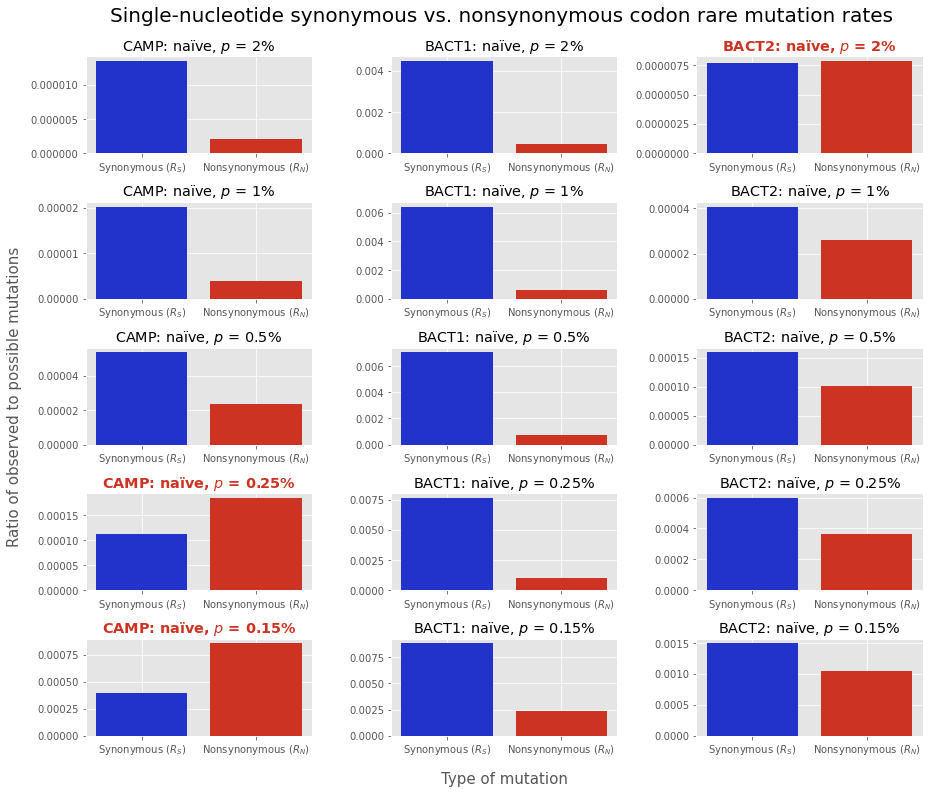

In [12]:
fig, axes = pyplot.subplots(len(percentages), 3, gridspec_kw={"hspace": 0.5, "wspace": 0.35})

if len(percentages) % 2 == 0:
    # Really, the precise middle is between two rows, right? anyway as of writing we use 7 percentages
    # so this never happens
    middle_row = len(percentages) / 2
else:
    middle_row = percentages.index(median(percentages))

for pi, p in enumerate(percentages):
    for si, seq in enumerate(SEQS):
        rs = p2seq2synvals[p][seq]["syn"]
        rn = p2seq2synvals[p][seq]["nonsyn"]
        axes[pi, si].bar(
            ["Synonymous ($R_S$)", "Nonsynonymous ($R_N$)"],
            [rs,rn],
            color=["#2233cc", "#cc3322"]
        )
        axes[pi, si].ticklabel_format(axis="y", style="plain")
        
        titlecolor="#000000"
        titleweight="normal"
        if rs <= rn:
            titlecolor = "#cc3322"
            titleweight = "semibold"
            
        axes[pi, si].set_title(f"{seq2name[seq]}: {get_suffix(p)}", color=titlecolor, fontweight=titleweight)
        
        if pi == middle_row and si == 0:
            axes[pi, si].set_ylabel("Ratio of observed to possible mutations", labelpad=15, fontsize=15)

axes[len(percentages) - 1, 1].set_xlabel("Type of mutation", labelpad=15, fontsize=15)
fig.suptitle("Single-nucleotide synonymous vs. nonsynonymous codon rare mutation rates", y=0.935, x=0.51, fontsize=20)
fig.set_size_inches(15, 12.5)
fig.savefig("figs/syn-nonsyn-snmut-barplots.png", bbox_inches="tight")

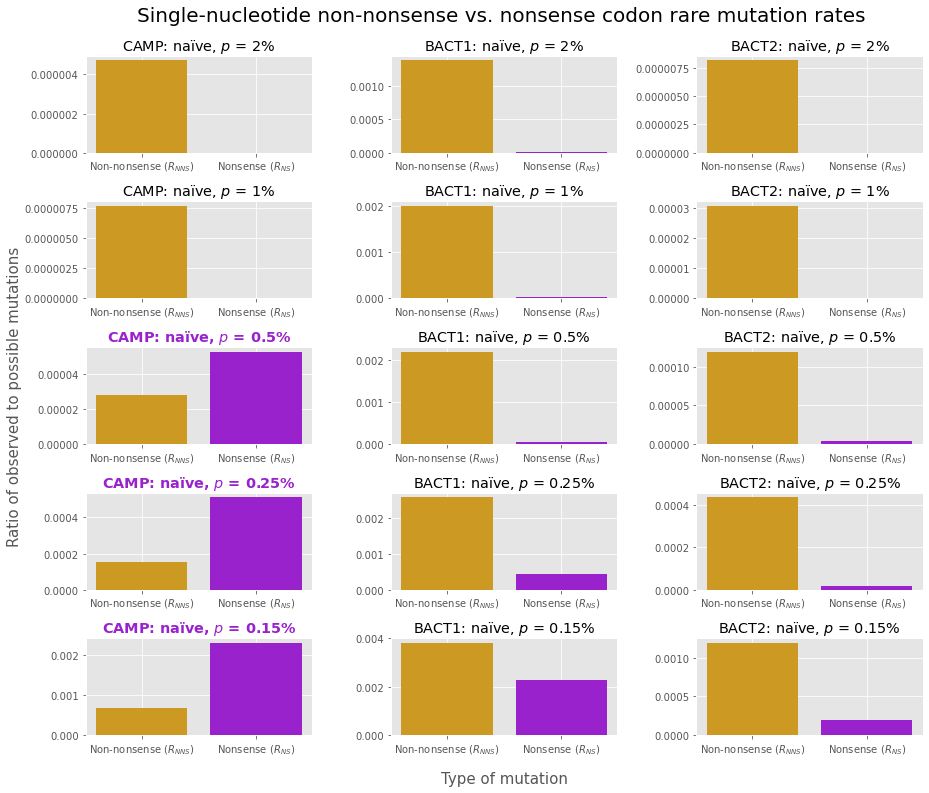

In [13]:
fig2, axes2 = pyplot.subplots(len(percentages), 3, gridspec_kw={"hspace": 0.5, "wspace": 0.35})

for pi, p in enumerate(percentages):
    for si, seq in enumerate(SEQS):
        rnns = p2seq2nonsensevals[p][seq]["nonnonsense"]
        rns = p2seq2nonsensevals[p][seq]["nonsense"]
        axes2[pi, si].bar(
            ["Non-nonsense ($R_{NNS}$)", "Nonsense ($R_{NS}$)"],
            [rnns, rns],
            color=["#cc9922", "#9922cc"]
        )
        
        # Turn off scientific notation on the y-axis' ticks -- for some very small numbers
        # for CAMP's mutation rates, matplotlib will default to scaling the y-axis tick values by 1e-5.
        # See https://stackoverflow.com/a/28373421: the axis="y" argument is needed because by default
        # this'll try to apply this to *both* axes, and the categorical x-axis causes an error.
        axes2[pi, si].ticklabel_format(axis="y", style="plain")
        
        titlecolor = "#000000"
        titleweight = "normal"
        if rnns <= rns:
            titlecolor = "#9922cc"
            titleweight = "semibold"
            
        axes2[pi, si].set_title(f"{seq2name[seq]}: {get_suffix(p)}", color=titlecolor, fontweight=titleweight)
        
        if pi == middle_row and si == 0:
            axes2[pi, si].set_ylabel("Ratio of observed to possible mutations", labelpad=15, fontsize=15)
        
axes2[len(percentages) - 1, 1].set_xlabel("Type of mutation", labelpad=15, fontsize=15)
fig2.suptitle("Single-nucleotide non-nonsense vs. nonsense codon rare mutation rates", y=0.935, x=0.51, fontsize=20)
fig2.set_size_inches(15, 12.5)
fig2.savefig("figs/nonnonsense-nonsense-snmut-barplots.png", bbox_inches="tight")

## Misc. text info about BACT1, to help with explanation

### For the $R_S$ and $R_N$ section

#### Example of rate computation with BACT1

In [48]:
for seq in SEQS:
    rs = p2seq2synvals[0.5][seq]['syn']
    rn = p2seq2synvals[0.5][seq]['nonsyn']
    # Sloppy way of autogenerating text for the paper -- i know that trying to automate
    # this is like writing in the sand, but this way i save a bit of personal sanity
    rs_to_rn = rs / rn
    if rs_to_rn > 8 and rs_to_rn < 12:
        comp = "an order of magnitude larger than"
    elif rs > rn:
        comp = f"{rs_to_rn:.1f} times larger than"
    else:
        # if you have wound up at this branch of this if-else statement, may god have mercy on your soul
        raise ValueError("Hey Marcus you should update the code here lol")
    
    jkclarif = "%"
    if seq == "edge_1671":
        jkclarif = "(Note that $J + K = 3N$.)\n%"
    
    outputtext = fr"""For the {seq2name[seq]} genome
(where $N$ = {seq2total_codon_nt_len[seq]:,}),
there are $J$ = {seq2poss_si[seq]:,} possible synonymous and
$K$ = {seq2poss_ni[seq]:,} possible nonsynonymous single-nucleotide mutations.
{jkclarif}
Using the mutation frequency threshold $p = 0.5\%$,
the {seq2name[seq]} genome contains
$X$ = {p2seq2obs_si[0.5][seq]:,} synonymous and
$Y$ = {p2seq2obs_ni[0.5][seq]:,} nonsynonymous rare single-nucleotide mutations.
%
Thus, the ratio of observed to possible synonymous single-nucleotide mutations
($R_S = X / J = \frac{{{p2seq2obs_si[0.5][seq]:,}}}{{{seq2poss_si[seq]:,}}}
\approx {rs:.5f}$)
is {comp} the ratio of observed to possible nonsynonymous single-nucleotide mutations
($R_N = Y / K = \frac{{{p2seq2obs_ni[0.5][seq]:,}}}{{{seq2poss_ni[seq]:,}}}
\approx {rn:.5f}$)
for {seq2name[seq]}.
"""
    
    # it's MY jupyter notebook and I get to use the weird-ass docstrings that break indentation
    if seq == "edge_6104":
        
        num = p2seq2obs_si[0.5][seq] + p2seq2obs_ni[0.5][seq]
        rt = num / (3 * seq2total_codon_nt_len[seq])
        lowered_muts = (num * rn) / rt
        frac = (lowered_muts / (seq2total_codon_nt_len[seq] / 3)) * 1000000
        
        outputtext += fr"""%
The lower rate of nonsynonymous mutations can be used to produce a new FDR estimate
as follows, using the $K$ possible nonsynonymous single-nucleotide mutations
in {seq2name[seq]} as a decoy database.
%
We compute the total rate of possible (synonymous and nonsynonymous) single-nucleotide mutations
in {seq2name[seq]} as $R_{{S + N}} =
\frac{{{p2seq2obs_si[0.5][seq]:,} + {p2seq2obs_ni[0.5][seq]:,}}}{{3 \cdot {seq2total_codon_nt_len[seq]:,}}}
\approx {rt:.5f}$, and use $R_N$ to lower the effective number of
codon mutations in {seq2name['edge_6104']} from $X + Y =$ {num:,} to
$\frac{{{num} \cdot R_N}}{{R_{{S + N}}}} =
\frac{{{num} \cdot {rn:.5f}}}{{{rt:.5f}}} \approx {lowered_muts:,.1f}$.
%
We can compute the number of mutations per megabase by dividing this value by $N / 3$,
the total number of codons in {seq2name['edge_6104']} (and then multiplying by 1,000,000):
this gives us a new value of
$frac_{{decoy}} \approx {frac:,.1f}$ which we can use for FDR estimation.
% (The math works out so that we can just compute frac_decoy directly with 9Y/K = 9*R_N,
% for reference.)
"""
    with open(f"misc-text/{seq2name[seq].lower()}-rs-rn-info.tex", "w") as of:
        of.write(f"{outputtext}\endinput")
    print(f"{'-' * 4}{seq2name[seq]}{'-' * 74}\n{outputtext}")

----CAMP--------------------------------------------------------------------------
For the CAMP genome
(where $N$ = 1,192,452),
there are $J$ = 741,223 possible synonymous and
$K$ = 2,836,133 possible nonsynonymous single-nucleotide mutations.
%
Using the mutation frequency threshold $p = 0.5\%$,
the CAMP genome contains
$X$ = 40 synonymous and
$Y$ = 67 nonsynonymous rare single-nucleotide mutations.
%
Thus, the ratio of observed to possible synonymous single-nucleotide mutations
($R_S = X / J = \frac{40}{741,223}
\approx 0.00005$)
is 2.3 times larger than the ratio of observed to possible nonsynonymous single-nucleotide mutations
($R_N = Y / K = \frac{67}{2,836,133}
\approx 0.00002$)
for CAMP.
%
The lower rate of nonsynonymous mutations can be used to produce a new FDR estimate
as follows, using the $K$ possible nonsynonymous single-nucleotide mutations
in CAMP as a decoy database.
%
We compute the total rate of possible (synonymous and nonsynonymous) single-nucleotide mutations
in CA

### For the $R_{NNS}$ and $R_{NS}$ section

In [15]:
# Some unused text I started writing before realizing that it isn't super important probably, but oh
# well the extra assertion is nice to keep in

n = seq2total_codon_nt_len['edge_1671']
s = seq2num_genes['edge_1671']
np = seq2sense_codon_nt_len['edge_1671']
assert np == (n - (3 * s))

print(fr"""
For all genomes, $N' = N - 3S$, where $N$ is the total number of
nucleotides located in all codons (sense and stop), and $S$ is the total number of stop codons
located in all predicted genes throughout the the genome (this number should be equal to the
total number of predicted genes, since each gene should have only a single associated stop codon).
The {seq2name['edge_1671']} genome has $N = {n:,}$,
$3S = {3 * s:,}$, and $N' = {np:,}$,
so $N' = N - S$ holds.
""")


For all genomes, $N' = N - 3S$, where $N$ is the total number of
nucleotides located in all codons (sense and stop), and $S$ is the total number of stop codons
located in all predicted genes throughout the the genome (this number should be equal to the
total number of predicted genes, since each gene should have only a single associated stop codon).
The BACT1 genome has $N = 1,947,597$,
$3S = 5,283$, and $N' = 1,942,314$,
so $N' = N - S$ holds.



In [16]:
# NOTE: we use {{ }} (doubling up on curly braces) in order to escape them --
# https://stackoverflow.com/a/5466478
# We could probs also just split this up into multiple strings but that's woooork

for seq in SEQS:
    
    nns = p2seq2nonsensevals[0.5][seq]['nonnonsense']
    ns = p2seq2nonsensevals[0.5][seq]['nonsense']
    if nns > ns:
        comparison = "is larger than"
    elif nns == ns:
        # this case is completely fine, but i doubt it'll ever happen lol
        raise ValueError("if you see this error message, you should probably go get a drink")
    else:
        comparison = "is unexpectedly smaller than"
        
    outputtext = fr"""We consider the {seq2name[seq]} genome at the threshold $p = 0.5\%$.
%
In this genome, there are $N'$ = {seq2sense_codon_nt_len[seq]:,} nucleotides
located throughout all sense codons (we ignore stop codons in the reference genome).
%
{seq2name[seq]} has $J$ = {seq2poss_nnsi[seq]:,} possible non-nonsense and
$K$ = {seq2poss_nsi[seq]:,} possible nonsense single-nucleotide mutations.
%
Using $p = 0.5\%$, {seq2name[seq]} contains
$X$ = {p2seq2obs_nnsi[0.5][seq]:,} non-nonsense and
$Y$ = {p2seq2obs_nsi[0.5][seq]:,} nonsense rare single-nucleotide mutations.
%
At $p = 0.5\%$, then, the ratio of observed to possible non-nonsense single-nucleotide mutations
($R_{{NNS}} = X / J = \frac{{{p2seq2obs_nnsi[0.5][seq]:,}}}{{{seq2poss_nnsi[seq]:,}}}
\approx {nns:.5f}$)
{comparison} the ratio of observed to possible nonsynonymous single-nucleotide mutations
($R_{{NS}} = Y / K = \frac{{{p2seq2obs_nsi[0.5][seq]:,}}}{{{seq2poss_nsi[seq]:,}}}
\approx {ns:.5f}$)
for {seq2name[seq]}.
"""
    with open(f"misc-text/{seq2name[seq].lower()}-rnns-rns-info.tex", "w") as of:
        of.write(f"{outputtext}\endinput")
        print(f"{'-' * 4}{seq2name[seq]}{'-' * 74}\n{outputtext}")

----CAMP--------------------------------------------------------------------------
We consider the CAMP genome at the threshold $p = 0.5\%$.
%
In this genome, there are $N'$ = 1,188,561 nucleotides
located throughout all sense codons (we ignore stop codons in the reference genome).
%
CAMP has $J$ = 3,395,872 possible non-nonsense and
$K$ = 169,811 possible nonsense single-nucleotide mutations.
%
Using $p = 0.5\%$, CAMP contains
$X$ = 96 non-nonsense and
$Y$ = 9 nonsense rare single-nucleotide mutations.
%
At $p = 0.5\%$, then, the ratio of observed to possible non-nonsense single-nucleotide mutations
($R_{NNS} = X / J = \frac{96}{3,395,872}
\approx 0.00003$)
is unexpectedly smaller than the ratio of observed to possible nonsynonymous single-nucleotide mutations
($R_{NS} = Y / K = \frac{9}{169,811}
\approx 0.00005$)
for CAMP.

----BACT1--------------------------------------------------------------------------
We consider the BACT1 genome at the threshold $p = 0.5\%$.
%
In this genome, t